In [1]:
import pandas as pd
import streamlit as st
import graphviz
import itertools
import re
from copy import deepcopy

In [2]:
# =============================================================================
# Service functions
# =============================================================================
# Common block 
# =============================================================================
def get_df_log(str_log):
    '''
    Event log transformation from str ('[<acd>45, <bce>42]') to pandas.DataFrame (columns = ['trace','qty'])
    '''
    return pd.DataFrame({'trace':re.findall('[a-z]+', str_log),'qty':[int(s) for s in re.findall('[0-9]+', str_log)]})
# =============================================================================
# Exercise #1 - Alpha Algorithm
# =============================================================================
def get_DFG (traces_list, qty_list):
    '''
    Computing the DFG nodes - (activity, frequency), and
    the DFG arcs - ((activity,activity), frequency)

    Parameters
    ----------
    traces_list : list
        list of traces (e.g. traces_list = ['acd','bce'])
    qty_list : list
        list of frequencies of traces (e.g. qty_list = [45,42] )
    Returns
    -------
    DFG_nodes_agg : pandas.DataFrame
        2 columns: 'act' - activities, 'qty' - their frequencies in the event log
    DFG_arcs_agg : pandas.DataFrame
        2 columns: 'pair' - arcs, 'qty' - their frequencies in the event log
    
    Example
    -------
    DFG_nodes, DFG_arcs = get_DFG (list(df_log['trace']), list(df_log['qty']))
    '''   
    # create internal pd.DataFrame based on input data
    L = pd.DataFrame({'trace_full':traces_list, 'qty': qty_list})
    # =============================================================================
    # NODES (ACTIVITIES)
    # function get_activities returns pd with pairs (activity, frequency) for one trace ('abc') with frequency (20)
    get_activities = lambda trace, qty: pd.DataFrame({'act':list(trace),'qty':qty})
    # compute DFG nodes as pd for all traces using the function get_activities
    L['nodes'] = list(map(lambda trace, qty: get_activities(trace, qty), L['trace_full'], L['qty']))
    # merge and aggregate all DFG nodes with sorting in descending frequency
    DFG_nodes = pd.concat([L.iloc[i]['nodes'] for i in list(L.index)])
    DFG_nodes_agg = pd.DataFrame(DFG_nodes.groupby(['act']).sum()).sort_values(by=['qty'], ascending=False).reset_index()
    # =============================================================================
    # EDGES (ARCS)
    # function get_pairs returns pd with pairs (arc, frequency) for one trace ('abc') with frequency (20)
    get_pairs = lambda trace, qty: pd.DataFrame({'pair':list(map(lambda s1, s2: s1 + s2, trace[:-1], trace[1:])),'qty':qty})
    # compute DFG edges (arcs) as pd for all traces using the function get_pairs
    L['arcs'] = list(map(lambda trace, qty: get_pairs(trace, qty), L['trace_full'], L['qty']))
    # merge and aggregate all DFG nodes with sorting in descending frequency
    DFG_arcs = pd.concat([L.iloc[i]['arcs'] for i in list(L.index)])
    DFG_arcs_agg = pd.DataFrame(DFG_arcs.groupby(['pair']).sum()).sort_values(by=['qty'], ascending=False).reset_index()
    
    return DFG_nodes_agg, DFG_arcs_agg

def get_vDFG(DFG_arcs, DFG_nodes, DFG_orientation,S,E):
    '''
    Creating the DFG by Graphviz 

    Parameters
    ----------
    DFG_arcs : pandas.DataFrame
        table with arcs (2 columns: 'pair' - arcs, 'qty' - their frequencies in the event log)
    DFG_nodes : pandas.DataFrame
        table with nodes (2 columns: 'act' - activities, 'qty' - their frequencies in the event log)
    DFG_orientation : str
        'LR' or 'TB' (left -> right or top -> bottom)
    S : str
        symbol for the artificial activity 'Start'- 'I'
    E : str
        symbol for the artificial activity 'End'- 'O'

    Returns
    -------
    <class 'bytes'>
        vDFG.pipe() for vizualization by st.image(vDFG)
    Example
    -------
    vDFG = get_vDFG(DFG_arcs, DFG_nodes, dfg_orientation,'I','O')
    '''
    # init graph
    vDFG = graphviz.Digraph('finite_state_machine')
    vDFG.attr(rankdir = DFG_orientation, size = '1000,1000') 
    vDFG.format = 'png'
    # DFG NODES 
    for i in DFG_nodes.index:
        # start or end - double circles
        if (DFG_nodes['act'].loc[i] == S)|(DFG_nodes['act'].loc[i] == E):
            vDFG.attr('node', shape='doublecircle')
            vDFG.node(DFG_nodes['act'].loc[i], label = DFG_nodes['act'].loc[i])
        else:
            vDFG.attr('node', shape='circle')
            vDFG.node(DFG_nodes['act'].loc[i], label = DFG_nodes['act'].loc[i])
    # DFG EDGES 
    for j in DFG_arcs.index:
        vDFG.edge(DFG_arcs['pair'].loc[j][0], DFG_arcs['pair'].loc[j][1], label = str(DFG_arcs['qty'].loc[j]))
    return vDFG

def get_footprint(in_pairs,in_qty_list,S,E):
    '''
    Computing the alternative DFG representations:
    - matrix with frequencis of arcs, 
    - footprint with relations between activities.

    Parameters
    ----------
    in_pairs : list
        list of arcs, i.e. in_pairs = ['Sa','eE']
    in_qty_list : list
        list of frequencies of arcs  (e.g. in_qty_list = [45,42] )
    S : str
        Start symbol (e.g. S = 'I')
    E : str
        Start symbol (e.g. E = 'O')

    Returns
    -------
    df_footprint : pandas.DataFrame
        table with relations between activities (columns and rows - [I,a,b,...,O])
    dict_footprint : dict
        footprint as a dictionary (i.e. dict_footprint['ab'] can returns string '||')

    '''
    # function to get relation between activities in pair
    get_rel = lambda pair,pairs: "||" if (''.join(list(pair)[::-1])) in pairs else "→"
    # get relation and qty lists
    rel = list(map(lambda ss: get_rel(ss, in_pairs), in_pairs))
    # get reverse pairs/relations
    in_pairs_reverse = list(map(lambda ss: ''.join(list(ss)[::-1]), in_pairs))
    rel_reverse = list(map(lambda ss: "||" if (ss == "||") else "←", rel))
    # get full df with index = pairs & rel - relation plus transform it to dict
    arcs_full = pd.DataFrame({'rel':rel+rel_reverse}, index = in_pairs+in_pairs_reverse)
    arcs_dict = arcs_full['rel'].to_dict()
    # get sorted activity list
    act_nodes = list(set(list(''.join(in_pairs).replace(S,'').replace(E,'')))) # without S, E
    act_sorted = [S]+sorted(act_nodes)+[E]
    # get the result df
    df_footprint = pd.DataFrame(index = act_sorted)
    for col in act_sorted:
        df_footprint[col] = list(map(lambda ss: 
                                     arcs_dict[ss+col] if (ss+col) in list(arcs_full.index) else '#', act_sorted))
    # get footprint dict
    all_arcs = [''.join(list(s)) for s in list(itertools.product(act_sorted,act_sorted))]
    other_arcs = list(set(all_arcs) - set(arcs_full.index))   # dict with ''#''
    dict_footprint = {ss: '#' for ss in other_arcs} | arcs_dict  # merge two dicts
    return df_footprint, dict_footprint

def split_nodes(in_nodes, arcs_connect_all): 
    '''
    Split the input set of activities into a list of subsets, 
    where each subset is a set of actvities with only # relations.  

    Parameters
    ----------
    in_nodes : set
        Set of activities for splitting,
        e.g. {'e', 'f', 'c', 'd'}.
    arcs_connect_all : set
        Set of all arcs in the DFG (non # relations),
        e.g. {'bd', 'ec', 'eg', 'bf',...}.
    Returns
    -------
    nodes : list of sets
        List of sets, where each set is the set of actvities with # relations,  
        e.g. [{'e', 'f'}, {'c', 'f'}, {'d', 'e'}, {'c', 'd'}].

    '''
    nodes = [deepcopy(in_nodes)]   # an initial list with one input set
    # get all posible pairs based on activities from the input set
    # permutations(p[,r]): r-length tuples, all possible orderings, no repeated elements ('aa' pairs are not required)
    arcs = {''.join(list(s)) for s in list(itertools.permutations(in_nodes,2))}  
    # get not # arcs from all posible pairs 'arcs'
    arcs_connected = arcs.intersection(arcs_connect_all)
    # merge pairs 'cd' and 'dc' into one 'cd'
    arcs_connected_ordered = {''.join(sorted(s)) for s in arcs_connected} 
    # split initial set into subsets with non-connected nodes
    for carc in arcs_connected_ordered: 
        nodes_split = []
        for node in nodes: 
            nodes_split.append({char for char in node if char != carc[0]})
            nodes_split.append({char for char in node if char != carc[1]})
        nodes = deepcopy(nodes_split)
    return nodes

def get_max_candidates(nodes_list, arcs_list, dict_fp):
    '''
    Get all maximal candidates for the Petri net places

    Parameters
    ----------
    nodes_list : list
        list of the DFG nodes,
        e.g. ['I','O','g','b','d','f','a','c','e']
    arcs_list : list
        list of the DFG arcs,
        e.g. ['gO','Ib','Ia','bf','dg','fd','ae','cg','ec','ac','bd','ce','df','eg','fg']
    dict_fp : dict
        full dictionary of relationships between DFG nodes (size NxN, N - qty of nodes),
        e.g. {'ed':'#',...,'gO':'→',...,'fd':'||',...,'bI':'←',...}
    Returns
    -------
    A1A2_full : list of lists of sets
        all maximal candidates,
        e.g. [[{'a'},{'e'}], [{'a'},{'c'}], [{'e','f'},{'g'}], [{'c','f'},{'g'}],
         [{'d','e'},{'g'}], [{'c','d'},{'g'}], [{'g'},{'O'}], [{'I'},{'a','b'}],
         [{'b'},{'f'}],[{'b'}, {'d'}]]

    '''
    # get the set of all nodes from the input - nodes_list
    nodes_all = set(nodes_list)
    # get the set of all nodes that are self connected (loops of length 1) - a||a
    nodes_self_connected =  {x for x in nodes_all if dict_fp[x+x]=='||'}
    
    # get the set of all arcs from the input - arcs_list
    arcs_connect_all = set(arcs_list)  # relations are || or -> or <-
    # get the set of all possible arcs for the nodes_all  - product(p,q) - cartesian product, equivalent to a nested for-loop
    arcs_all  = set(''.join(list(s)) for s in list(itertools.product(nodes_all, nodes_all)))
    # get all arcs that connect activities directly (relation is '→')
    arcs_connect_direct = {x for x in arcs_all if (dict_fp[x]=='→')} # only → ('||' - exclude, '<-' are not necessary)

    # lookig for the maximal candidates   
    A1A2_full = []    # list of lists of sets for maximal candidates
    for a in nodes_all: # loop for all nodes, including I and O
        # select activities connected with 'a' on the right (xi: a-> xi)     
        A1A2 = [{a},{x for x in nodes_all if dict_fp[a+x] == '→' and x not in nodes_self_connected}]    
        # select activities connected with 'xi' on the left (yi: yi->xi)
        for x in A1A2[1]:
            A1A2[0] = A1A2[0].union({y for y in nodes_all if dict_fp[y+x] == '→' and y not in nodes_self_connected})
        # Check that each left activity is connected to all right activities, if not - remove it from the left ones
        for x in A1A2[0]:  
            x_arcs = {x+y for y in A1A2[1]}
            if len(x_arcs - arcs_connect_direct)>0: # here we detect 'a-b-a' relations (||) and exсlude them (loops of length 2)
                A1A2[0] = A1A2[0] - set(x)

        # check '#' in A1 (left) and A2 (right), if not # - split set
        left_nodes = split_nodes(A1A2[0], arcs_connect_all)
        if sum([len(x) for x in left_nodes])==0: 
            continue
            
        right_nodes = split_nodes(A1A2[1], arcs_connect_all)
        if sum([len(x) for x in right_nodes])==0: 
            continue    
            
        # get all candidates for left and right groups of nodes
        A1A2_candidates = [[a_left,a_right] for a_left in left_nodes for a_right in right_nodes]
        # check candidates with the general list
        for candidate in A1A2_candidates: 
            if not(candidate in A1A2_full):  # if the candidate is not in the general list: flag = True
                flag = True
                for selected in A1A2_full:   # check that candidate is maximal - if the candidate is a subset of some element of the general list: flag = False (not max)
                    if (candidate[0].issubset(selected[0]))&(candidate[1].issubset(selected[1])): 
                        flag = False
                    if (selected[0].issubset(candidate[0]))&(selected[1].issubset(candidate[1])): 
                        A1A2_full.remove(selected)    # if some element of the general list is a subset of candidate: delete the exiting element from the general list
                if flag: 
                    A1A2_full.append(candidate)  # add the candidate to the general list 
    return A1A2_full


def alpha_miner(traces_list, qty_list, a_start = 'I', a_end = 'O'):
    
    DFG_nodes, DFG_arcs = get_DFG(traces_list, qty_list)
    df_footprint, dict_footprint = get_footprint(list(DFG_arcs['pair']), list(DFG_arcs['qty']), a_start, a_end)
    max_candidates = get_max_candidates(list(DFG_nodes['act']), list(DFG_arcs['pair']), dict_footprint)
    # transitions   
    T = pd.DataFrame({'label':[a_start]+sorted(list(''.join(list(DFG_nodes['act'])).replace(a_start,'').replace(a_end,'')))+[a_end], 
                      'transition': [f'T{i}' for i in range(len(DFG_nodes['act']))]})
    T_label_dict = pd.DataFrame({'label':list(T['label'])}, index = list(T['transition']))['label'].to_dict()
    # places
    P = pd.DataFrame({'candidate': max_candidates,
                      'place':['P\n'+''.join(s[0]) +'_'+ ''.join(s[1]) for s in max_candidates]
                      }).sort_values(by='place')
    # arcs
    F = set()
    for i in P.index:
        for A1 in P.iloc[i]['candidate'][0]: F = F | {(A1, P.iloc[i]['place'])}
        for A2 in P.iloc[i]['candidate'][1]: F = F | {(P.iloc[i]['place'], A2)}
    # add Start(I) and End(O) to places and arcs
    P = pd.concat([pd.DataFrame({'candidate': [''],'place':['P\n'+a_start]}), P, pd.DataFrame({'candidate': [''],'place':['P\n'+a_end]})]).reset_index(drop=True)        
    F = list(F | {('P\n'+a_start,a_start)} | {(a_end,'P\n'+a_end)})
    return T, P, F, T_label_dict 
    
def get_vPetriNet(T,P,F,a_start='I',a_end='O',PN_orientation = 'LR'):
    '''
    Create the Petri net graph by Graphviz

    Parameters
    ----------
    T : list
        List of transition labels (activities including start and end),
        e.g. T = ['I','a','b','c','d','e','O'].
    P : list
        List of places, 
        e.g. P = ['P\nI','P\nI_a','P\na_bd','P\na_dc','P\nbd_e','P\ncd_e','P\ne_O','P\nO'],
        '\n' - visualization in two lines, 'a_bd' - label: left transition is 'a', right - 'b' and 'd'. 
    F : list 
        List of arcs in tuples: '(a,b)' is arc from 'a' to 'b' 
    a_start : str, optional
        Start activity designation. The default is 'I'.
    a_end : str, optional
        End activity designation. The default is 'O'.
    PN_orientation : str, optional
        'LR' or 'TB' (left -> right or top -> bottom). The default is 'LR'.

    Returns
    -------
    <class 'bytes'>
        vPetriNet.pipe() for vizualization by st.image(vPetriNet)

    '''
    # init graph
    vPetriNet = graphviz.Digraph('TrafficLights')
    vPetriNet.attr(rankdir = PN_orientation, size='1000,1000') 
    vPetriNet.format = 'png'
    # add transitions
    for t in T: 
        # highlight the start and end
        if t in [a_start]: vPetriNet.attr('node', width='0.3', fillcolor='#66FF66')
        elif t in [a_end]: vPetriNet.attr('node', width='0.3', fillcolor='#FF7C80')
        else: vPetriNet.attr('node', width='0.5', fillcolor='white')
        vPetriNet.attr('node', shape='box', fixedsize='true', style='filled', fontname = 'arial black', fontsize='12', fontcolor='black')            
        vPetriNet.node(t)  
    # add places
    for p in P:
        # highlight the start and end
        if p in ['P\n'+a_start]: vPetriNet.attr('node', shape='circle', fillcolor='#66FF66') 
        elif p in ['P\n'+a_end]: vPetriNet.attr('node', shape='doublecircle', fillcolor='#FF7C80') 
        else: vPetriNet.attr('node', shape='circle', fillcolor='white')            
        vPetriNet.attr('node', fixedsize='true', width='0.6', style='filled',  fontname = 'arial', fontsize='10', fontcolor='black') 
        vPetriNet.node(p)    
    # add arcs
    for f in F: 
        vPetriNet.edge(f[0],f[1])
    return vPetriNet 

# =============================================================================
# Special function to get texts in markdown format
# =============================================================================
def get_default_event_log(L):
    if   L == 'L1': return '[<abce>50,<acbe>40,<abcdbce>30,<acbdbce>20,<abcdcbe>10,<acbdcbdbce>10]'
    elif L == 'L2': return '[<aceg>2, <aecg>3,<bdfg>2,<bfdg>4]'
    elif L == 'L3': return '[<acd>45, <bce>42]'
    elif L == 'L4': return '[<abab>5, <ac>2]'
    elif L == 'L5': return '[<abce>10,<acbe>5,<ade>1]' 
    elif L == 'L6': return '[<ab>35, <ba>15]'
    elif L == 'L7': return '[<a>10, <ab>8,<acb>6,<accb>3,<acccb>1]'
    elif L == 'L8': return '[<abef>2,<abecdbf>3,<abcedbf>2,<abcdebf>4,<aebcdbf>3]'
    else: return '[<abce>50,<acbe>40,<abcdbce>30,<acbdbce>20,<abcdcbe>10,<acbdcbdbce>10]'

In [3]:
selection = "L7"

In [4]:
df_log = get_df_log(get_default_event_log(selection))

df_log['trace'] = 'I' + df_log['trace'] + 'O'  # add start & end
traces_list = list(df_log['trace'])
qty_list = list(df_log['qty'])

graph_orientation = "LR"

DFG_nodes, DFG_arcs = get_DFG (list(df_log['trace']), list(df_log['qty'])) # get DFG nodes & arcs
vDFG = get_vDFG(DFG_arcs, DFG_nodes, graph_orientation,'I','O')   # construct DFG as graphviz object
df_footprint, dict_footprint = get_footprint(list(DFG_arcs['pair']), list(DFG_arcs['qty']), 'I','O')

max_candidates = get_max_candidates(list(DFG_nodes['act']), list(DFG_arcs['pair']), dict_footprint)

T, P, F, T_label_dict = alpha_miner(traces_list, qty_list, 'I', 'O')
vPN = get_vPetriNet(list(T['label']), list(P['place']), F, 'I', 'O', graph_orientation)                

P['place(view)'] = [[s.replace('\n',' ')] for s in list(P['place'])]
F_view = pd.DataFrame({'arc':[(str(s)).replace('\\n',' ').replace("'","").replace('(','').replace(')','').split(',') for s in F]})
T['label_view'] = [[s] for s in list(T['label'])]

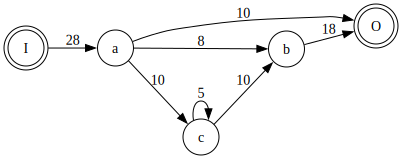

In [5]:
vDFG

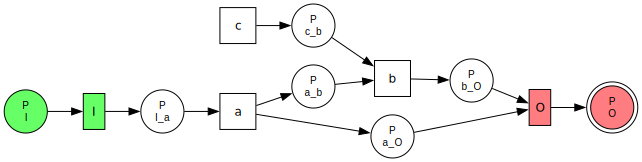

In [6]:
vPN

In [7]:
df_footprint

,I,a,b,c,O
I,#,→,#,#,#
a,←,#,→,→,→
b,#,←,#,←,→
c,#,←,→,||,#
O,#,←,←,#,#


In [13]:
selection = "L8"

In [14]:
traces = [(list(row["trace"]), row["qty"]) for _, row in get_df_log(get_default_event_log(selection)).iterrows()]
traces

[(['a', 'b', 'e', 'f'], 2),
 (['a', 'b', 'e', 'c', 'd', 'b', 'f'], 3),
 (['a', 'b', 'c', 'e', 'd', 'b', 'f'], 2),
 (['a', 'b', 'c', 'd', 'e', 'b', 'f'], 4),
 (['a', 'e', 'b', 'c', 'd', 'b', 'f'], 3)]

In [15]:
from miner.alpha_miner import AlphaMiner
from typing import *

In [16]:
miner = AlphaMiner()
miner.fit(traces)

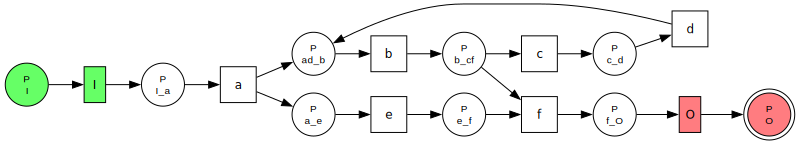

In [17]:
miner.generate_petri_net()

In [15]:
miner.maximal_candidates

[({'a'}, {'O'}),
 ({'a'}, {'b'}),
 ({'I'}, {'a'}),
 ({'c'}, {'b'}),
 ({'b'}, {'O'})]

In [17]:
graph = {
    "c": {"d", "f"},
    "d": {"e", "c"},
    "e": {"f", "d"},
    "f": {"c", "e"}
}

In [18]:
split_nodes2(graph)

[{'c', 'f'}, {'c', 'd'}, {'e', 'f'}, {'d', 'e'}]

In [134]:
%timeit -r 5 -n 5 split_nodes2(graph)

25.2 µs ± 7.3 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [125]:
in_nodes = {"c", "d", "e", "f"}
arcs_connect_all = list(DFG_arcs["pair"])

In [126]:
%timeit -r 5 -n 5 split_nodes(in_nodes, arcs_connect_all)

TypeError: split_nodes() takes 1 positional argument but 2 were given